In [1]:
## importing required libraries, we will go on importing in our notebook code as we require

import pandas as pd
from sklearn.model_selection import train_test_split
!pip install tensorflow
!pip install keras
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA

from numpy import concatenate

In [2]:
# defining a function

def lstm_lag(n):
    
    # reading data
    data = pd.read_csv('converted.csv')
    # shifting by specified lag
    data['Inflation (Can)'] = data['Inflation (Can)'].shift(-1*n)
    # other cleaning
    data = data.head(84*30)
    data.drop(['Period'],axis=1,inplace=True)

    # scaling the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    y = scaled_data[:,0]
    x = scaled_data[:,1:]
    
    # applying PCA to reduce number of features
    from sklearn.decomposition import PCA
    pca = PCA(n_components=5)
    scaled_data = pca.fit_transform(x)

    # splitting data into train and test sets
    train_X = scaled_data[:72*30]
    train_y = y[:72*30]
    test_X = scaled_data[72*30:84*30]
    test_y = y[72*30:84*30]

    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

    # training lstm with a network and other parameters
    model = Sequential()
    model.add(LSTM(128,activation='relu', input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True))
    model.add(LSTM(128,return_sequences=True))
    model.add(LSTM(64,return_sequences=True))
    model.add(LSTM(16,return_sequences=True))
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    history = model.fit(train_X, train_y, epochs=10, batch_size=30, validation_data=(test_X, test_y), verbose=0, shuffle=False)
    
    # plotting prediction results
    yhat = model.predict(test_X)
    # invert pca for forecast
    test_X1 = pca.inverse_transform(test_X.reshape((test_X.shape[0], test_X.shape[2])))
    # invert scaling for forecast
    inv_yhat = concatenate((yhat.reshape(12*30,1), test_X1), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    a = inv_yhat
    # invert scaling for actual
    test_y1 = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y1, test_X1), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    b = inv_y

    pyplot.plot(inv_yhat, label='predicted')
    pyplot.plot(inv_y, label='actual')
    pyplot.legend()
    pyplot.title(str(n)+'days lag')
    pyplot.savefig('lstm'+str(n)+'.png')
    pyplot.show()
    
    # printing mse and mae
    print('mse = ',mean_squared_error(a,b))
    print('mae = ',mean_absolute_error(a,b))
    
    return

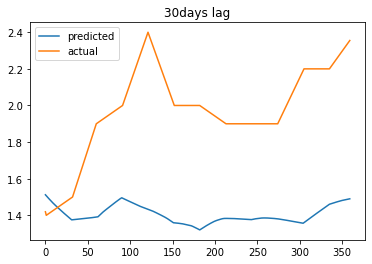

mse =  0.38216661494047544
mae =  0.5764331242055474


In [44]:
# change the number in argument from 0, 30, 60, 90 representing lag in number of days
lstm_lag(30)

# by running this cell, lstm model will be trained on data with specified lag
# it will give output the mse and mae
# it will show the graph of predictions and save that graph

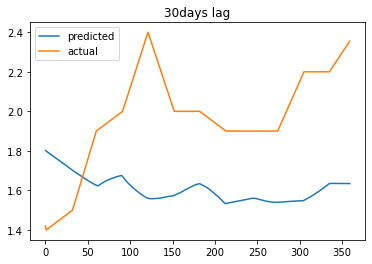

mse =  0.21253606342328024
mae =  0.4287719738235836
None


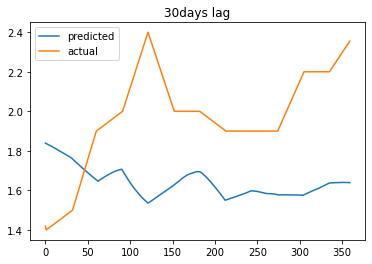

mse =  0.19807213120699343
mae =  0.41046661850542704
None


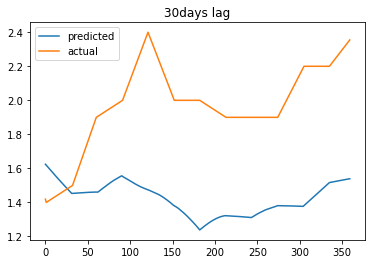

mse =  0.3720198571940666
mae =  0.5699873633694452
None


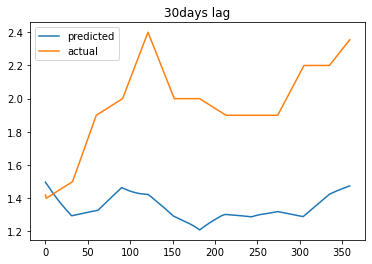

mse =  0.4546786999447857
mae =  0.6361122866465053
None


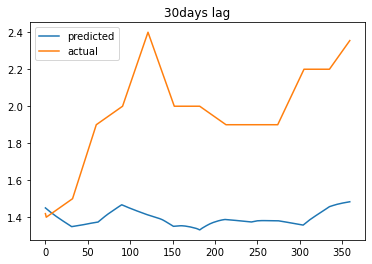

mse =  0.38997673993307896
mae =  0.5833064208215288
None


In [45]:
for i in range(5):
    print(lstm_lag(30))

In [6]:
# similar function for svm

def svm_lag(n):
    data = pd.read_csv('raw_data.csv')
    data['Inflation (Can)'] = data['Inflation (Can)'].shift(-1*n)
    data = data.head(84)
    data.drop(['Period'],axis=1,inplace=True)

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    y = scaled_data[:,0]
    x = scaled_data[:,1:]
    from sklearn.decomposition import PCA
    pca = PCA(n_components=5)
    scaled_data = pca.fit_transform(x)

    train_X = scaled_data[:72]
    train_y = y[:72]
    test_X = scaled_data[72:84]
    test_y = y[72:84]

    para = {
    'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
    'tol' : [0.0001,0.0005,0.001,0.01,0.1],
    'C' : [0.1,0.5,1,2]
    }
    grid_ser = GridSearchCV(SVR(),scoring = 'neg_mean_squared_error',param_grid=para ,n_jobs =1,cv = 4,verbose=0)
    grid_ser.fit(train_X,train_y)

    a = scaler.inverse_transform(
    concatenate(
    (grid_ser.best_estimator_.predict(test_X).reshape(12,-1),pca.inverse_transform(test_X)),
     axis=1
    )
    )[:,0]

    b = scaler.inverse_transform(
    concatenate(
    (test_y.reshape(12,-1),pca.inverse_transform(test_X)),
     axis=1
    )
    )[:,0]

    pyplot.plot(a, label='predicted')
    pyplot.plot(b, label='actual')
    pyplot.legend()
    pyplot.savefig('svm'+str(n)+'.png')
    pyplot.show()
    
    print('mse = ',mean_squared_error(a,b))
    print('mae = ',mean_absolute_error(a,b))
    
    return

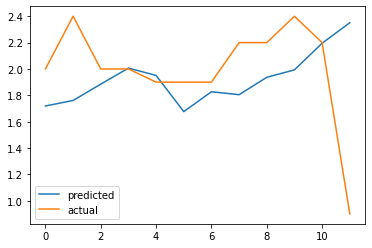

mse =  0.2545468916643924
mae =  0.32585220300191525


In [34]:
# change the number in argument from 0, 1, 2, 3 representing lag in number of months

svm_lag(3)

# a similar function as of lstm with same attributes

In [8]:
from sklearn.linear_model import LinearRegression

In [9]:
# similar function for svm

def regression_lag(n):
    data = pd.read_csv('raw_data.csv')
    data['Inflation (Can)'] = data['Inflation (Can)'].shift(-1*n)
    data = data.head(84)
    data.drop(['Period'],axis=1,inplace=True)

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    y = scaled_data[:,0]
    x = scaled_data[:,1:]
    from sklearn.decomposition import PCA
    pca = PCA(n_components=5)
    scaled_data = pca.fit_transform(x)

    train_X = scaled_data[:72]
    train_y = y[:72]
    test_X = scaled_data[72:84]
    test_y = y[72:84]

    para = {
    'n_jobs':[1,5,10,50]
    }
    grid_ser = GridSearchCV(LinearRegression(),scoring = 'neg_mean_squared_error',param_grid=para ,n_jobs =1,cv = 4,verbose=0)
    grid_ser.fit(train_X,train_y)

    a = scaler.inverse_transform(
    concatenate(
    (grid_ser.best_estimator_.predict(test_X).reshape(12,-1),pca.inverse_transform(test_X)),
     axis=1
    )
    )[:,0]

    b = scaler.inverse_transform(
    concatenate(
    (test_y.reshape(12,-1),pca.inverse_transform(test_X)),
     axis=1
    )
    )[:,0]

    pyplot.plot(a, label='predicted')
    pyplot.plot(b, label='actual')
    pyplot.legend()
    pyplot.savefig('svm'+str(n)+'.png')
    pyplot.show()
    
    print('mse = ',mean_squared_error(a,b))
    print('mae = ',mean_absolute_error(a,b))
    
    return

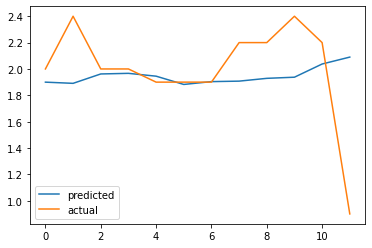

mse =  0.17414664589951248
mae =  0.26048888796924957


In [31]:
regression_lag(3)

In [46]:
data = pd.read_csv('converted.csv')

In [48]:
data.head(20)

,Period,Inflation (Can),Inflation (US),GDP (B$),Empl.Per. (M),CPI (Can),CPI (US),CC (Can),PC Util (Can),PC Util (US),...,Bus Conf (US),TSX,Retail YoY%,M3 T$,Gov Sp M$,EI (000s),Disp.Inc. M$,Consum.Cr. M$,Exports M$,Tourist Arr. (Persons)
0,2013-01-01,0.500000,1.600000,1729.586000,17.508000,121.300000,231.679000,53.900000,80.400000,76.700000,...,3.280000,12572.000000,1.400000,1.601576,127154.000000,539050.000000,343000.000000,605665.000000,38594.100000,1.215381e+06
1,2013-01-02,0.522581,1.612903,1729.754355,17.509477,121.345161,231.719581,53.951613,80.409677,76.709677,...,3.277419,12577.451613,1.429032,1.602049,127149.451613,538869.354839,343077.838710,605801.774194,38623.038710,1.215621e+06
2,2013-01-03,0.545161,1.625806,1729.922710,17.510955,121.390323,231.760161,54.003226,80.419355,76.719355,...,3.274839,12582.903226,1.458065,1.602523,127144.903226,538688.709677,343155.677419,605938.548387,38651.977419,1.215862e+06
3,2013-01-04,0.567742,1.638710,1730.091065,17.512432,121.435484,231.800742,54.054839,80.429032,76.729032,...,3.272258,12588.354839,1.487097,1.602996,127140.354839,538508.064516,343233.516129,606075.322581,38680.916129,1.216102e+06
4,2013-01-05,0.590323,1.651613,1730.259419,17.513910,121.480645,231.841323,54.106452,80.438710,76.738710,...,3.269677,12593.806452,1.516129,1.603469,127135.806452,538327.419355,343311.354839,606212.096774,38709.854839,1.216343e+06
5,2013-01-06,0.612903,1.664516,1730.427774,17.515387,121.525806,231.881903,54.158065,80.448387,76.748387,...,3.267097,12599.258065,1.545161,1.603942,127131.258065,538146.774194,343389.193548,606348.870968,38738.793548,1.216583e+06
6,2013-01-07,0.635484,1.677419,1730.596129,17.516865,121.570968,231.922484,54.209677,80.458065,76.758065,...,3.264516,12604.709677,1.574194,1.604416,127126.709677,537966.129032,343467.032258,606485.645161,38767.732258,1.216824e+06
7,2013-01-08,0.658065,1.690323,1730.764484,17.518342,121.616129,231.963065,54.261290,80.467742,76.767742,...,3.261935,12610.161290,1.603226,1.604889,127122.161290,537785.483871,343544.870968,606622.419355,38796.670968,1.217064e+06
8,2013-01-09,0.680645,1.703226,1730.932839,17.519819,121.661290,232.003645,54.312903,80.477419,76.777419,...,3.259355,12615.612903,1.632258,1.605362,127117.612903,537604.838710,343622.709677,606759.193548,38825.609677,1.217305e+06
9,2013-01-10,0.703226,1.716129,1731.101194,17.521297,121.706452,232.044226,54.364516,80.487097,76.787097,...,3.256774,12621.064516,1.661290,1.605835,127113.064516,537424.193548,343700.548387,606895.967742,38854.548387,1.217545e+06
